# Top-level imports

In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':180})

import sys
sys.path.append("/home/msdos/DESI-QA/desiarc-main/arc")
sys.path.append("/home/msdos/DESI-QA/")
sys.path.append("/home/msdos/DESI-QA/output/figures/")
import find_center as fc
from spotfinder import spotfinder
from xylib import calc_movetables as cm

figPath = '/home/msdos/DESI-QA/output/figures/LinPhiTests/50ArcTest/'

# Defining pertinent functions

In [695]:
def mount_to_label_raw(tupl):
    '''
    Function to take in a tuple of rowdata, and convert it to a string label representing the configuration
    Currently only configured for positioner up, positioner down, horizon
    '''
    if tupl[0]*tupl[1]==0:
        return "Horizon"
    elif tupl[0]*tupl[1]>0:
        return "Pos Down"
    else:
        return "Pos Up"
    
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, date=None, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
   
    if date is not None:
        return db['session'] == np.datetime64(date)
 
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
     
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0, grid=True):
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')
    if grid:
        plt.grid(linestyle='--',linewidth=0.5)
        
        
def get_dbxy(db,  datemin, datemax, label):
    mxy = db["label"].str.contains(label)
    mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    print(db.session[mxy].unique())
    dbxy = db[['xpix','ypix']][mxy].reindex()
    print(dbxy.shape)
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy


def plot_circle(xc, yc, R, kwargs={},axs = None):
    _th = np.linspace(0, 2*np.pi)
    if axs !=None:
        axs.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='green', ls='--', lw=0.6)
    else:
        plt.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='green', ls='--', lw=0.6)
    return 


def plot_xy(label, datemin, datemax, fig,ax,movefn, title='', show=True,save=False,pathname=None):
    dbxy = get_dbxy(db, datemin, datemax,label=label)
    xytgt = pd.read_csv(f"../movetables/{movefn}", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']

    ax.scatter('xpos', 'ypos', data=dbxy, c='black', marker ='+', s=30)#c=dbxy.index,cmap='Blues', edgecolors='b')
    # # plt.colorbar()
    ax.scatter('xpos', 'ypos', data=xytgt, facecolors='none',edgecolors='r', s=10, c='red', lw=0.5,label='target')
    ax.set_xlabel('xpos (mm)')
    ax.set_ylabel('ypos (mm)')
    ax.set_title(title, fontsize=8)
#     ax.set_xlim(-8,8)
    plt.gca().set_aspect('equal')
    plt.legend(loc='lower left', fontsize=8)
    if save:
        plt.savefig(pathname,dpi=180)
    if show:
        plt.show()
    return dbxy, xytgt
    # plt.legend(loc='best', fontsize=7)
    
def plot_formatting(num=1):
    fig,ax = plt.subplots(1,int(num),figsize=[6,6*int(num)])
    plot_circle(0,0, rPositioner)
    plt.grid(lw=0.6, ls='--')
    plt.plot(-np.linspace(0, rPositioner* np.cos(hardstopAngle)), np.linspace(0, rPositioner* np.sin(hardstopAngle)), lw=1 , c='g', label='hardstop'  )

    ax.set_xlim(-7,7)
    ax.set_ylim(-7,7)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    return fig,ax

def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def get_moveDirection(label,ABS=False):
    '''
    Function to take xy positions from a movetable and 
    return the theta and phi moves in separate arrays
    
    Here, CW is defined as positive and CCW is defined as negative
    '''

    df = pd.read_csv("/home/msdos/DESI-QA/movetables/"+label+".txt",sep=" ",names=["x","y"])
    
    theta_arr = np.array([0]) # set initial move direction to 0, since it can vary based on previous position - possible place to revise in the future, if necessary
    phi_arr = np.array([0])

    for j in range(len(df)-1):
        current = (j+1)
        old = j

        x_old,y_old = (df["x"][old],df["y"][old])
        x_current,y_current = (df["x"][current],df["y"][current])

        row = cm(hardstopAngle,R1,R2,x_old,y_old,x_current,y_current)

        if len(row)==1:
            if row[0][1]=='theta':
                phi_arr = np.append(phi_arr,0)
                if row[0][0]=="cw":
                    theta_arr = np.append(theta_arr,row[0][2])
                else:
                    theta_arr = np.append(theta_arr,-row[0][2])
            elif row[0][1]=='phi':
                theta_arr = np.append(theta_arr,0)
                if row[0][0]=="cw":
                    phi_arr = np.append(phi_arr,row[0][2])
                else:
                    phi_arr = np.append(phi_arr,-row[0][2])
            else:
                print("Rows from movetable are incompatible with storage settings - please check movetable!")
                print("Row "+str(j))
                break
        elif len(row)==2:

            if row[0][0]=="cw":
                theta_arr = np.append(theta_arr,row[0][2])
            else:
                theta_arr = np.append(theta_arr,-row[0][2])

            if row[1][0]=="cw":
                phi_arr = np.append(phi_arr,row[1][2])
            else:
                phi_arr = np.append(phi_arr,-row[1][2])
        else:
            print("Rows from movetable are incompatible with storage settings - please check movetable!")
            print("Row "+str(j))
            break
    if ABS:
        theta_arr = np.abs(theta_arr)
        phi_arr = np.abs(phi_arr)
    return theta_arr,phi_arr

def aligned(df1,df1_label,df2,df2_label):
    '''
    Function to test if df1 and df2 are aligned, by using a pre-defined axis label of identical keys
    Returns True if df1 and df2 are aligned, and False if not
    '''
    if len(df1)!=len(df2): # If mismatched length, obviously not aligned
        return False
    else:
        for entry in range(len(df1)):
            if df1.loc[entry][df1_label]!= df2.loc[entry][df2_label]:
                return False
        return True
    
def getSessions(df):
    '''
    Function to get indices of single arc sequences
    Returns session_ranges array, which contains all indices where a new arcsequence session either started or stopped
    '''
    session_ranges = np.array([-1],dtype=int)
    for i in range(len(df)-1):
        if (df.loc[i]['direction']!=df.loc[i+1]['direction']) and (df.loc[i]['direction']=='ccw') and (df.loc[i+1]['direction']=='cw'):
            session_ranges = np.append(session_ranges,i)
    session_ranges = np.append(session_ranges,len(df)-1)
    return session_ranges

def getOneSession(df,index,sessions_arr):
    '''
    Function to return a dataframe of a single arc-sequence session
    '''
    return df.loc[sessions_arr[index]+1:sessions_arr[index+1]]

def getDiff(sessions,k):
    '''
    Small helper function to get the difference in the total number of moves in a given session
    '''
    return sessions[k+1]-sessions[k]+1


def phi_centers(df,sessions):
    '''
    Function to calculate the center of a given arcsequence
    Uses the mean value of the pix2mm values from that session to calculate the center point
    '''
    xc2_arr,yc2_arr,R2_arr,xc2_pix_arr,yc2_pix_arr,pix2mm_arr = np.array([],dtype=float),np.array([],dtype=float),np.array([],dtype=float),np.array([],dtype=float),np.array([],dtype=float),np.array([],dtype=float)
    for j in range(len(sessions)-1):
        singleDF = getOneSession(df,j,sessions)
        xc2, yc2, R2 = [i*singleDF['pix2mm'].mean() for i in fc.get_circle(singleDF)]
        for k in range(getDiff(sessions,j)-1):
            pix2mm_arr = np.append(pix2mm_arr,singleDF['pix2mm'].mean())
            xc2_arr,yc2_arr,R2_arr = np.append(xc2_arr ,xc2), np.append(yc2_arr ,yc2), np.append(R2_arr ,R2)
            xc2_pix_arr, yc2_pix_arr = np.append(xc2_pix_arr, xc2/pix2mm), np.append(yc2_pix_arr, yc2/pix2mm)
    return xc2_arr,yc2_arr,R2_arr,xc2_pix_arr,yc2_pix_arr

def set_MountConfig_String(df):
    '''
    Function to set the mount configuration in string form, based on the mount angles
    '''
    labels = np.array([],dtype=str)
    for j in range(len(df)):
        labels = np.append(labels,mount_to_label_raw((df.loc[j]['mtang1'],df.loc[j]['mtang2'])))
    return labels

def makeSessionLabels(sessions):
    '''
    Function to make session labels based on sessions and the dataframe
    '''
    testArr = np.array([],dtype=int)
    for j in range(len(sessions)-1):
        testArr = np.append(testArr,np.repeat(j, getDiff(sessions,j)-1))
    return testArr

def getAlphas(df,backlash = 1.9,ramp=1.995):
    '''
    Function to return arrays of alpha, required move [degrees], and observed move [degrees]
    '''

    alpha_arr = np.array([],dtype='float16')
    req_arr = np.array([],dtype='float16')
    obs_arr = np.array([],dtype='float16')

    for k in range(max(df['ArcSession'])+1):
        arcs = df.loc[df['ArcSession']==k].reset_index(drop=True)
        xc2_pix,yc2_pix = arcs['xc2 pix'].loc[0],arcs['yc2 pix'].loc[0]
        
        alpha_arr = np.append(alpha_arr , np.nan)
        req_arr = np.append(req_arr , np.nan)
        obs_arr = np.append(obs_arr , np.nan)
        
        for j in range(len(arcs)-1):
            prev = j
            current = j+1

            x_previous, y_previous,direction_previous = arcs.loc[prev]['xpix'],arcs.loc[prev]['ypix'],arcs.loc[prev]['direction']
            x_current, y_current,direction_current = arcs.loc[current]['xpix'],arcs.loc[current]['ypix'],arcs.loc[current]['direction']

            if direction_previous!=direction_current or (k==0 and j==0) or j==0:
                alpha_arr = np.append(alpha_arr,angle_between((xc2_pix,yc2_pix),(x_previous, y_previous),
                                                              (x_current, y_current))/(arcs.loc[current]['angle']+2*ramp-backlash))
                req_arr = np.append(req_arr,arcs.loc[current]['angle']+2*ramp-backlash)

            else:
                alpha_arr = np.append(alpha_arr,angle_between((xc2_pix,yc2_pix),(x_previous, y_previous),(x_current, y_current))/(arcs.loc[current]['angle']+2*ramp))
                req_arr = np.append(req_arr,arcs.loc[current]['angle']+2*ramp)

            obs_arr = np.append(obs_arr, angle_between((xc2_pix,yc2_pix),(x_previous, y_previous),(x_current, y_current)))
    return alpha_arr, req_arr, obs_arr

def getMeans(df,label='Alpha'):
    '''
    Function to return means of each session, repeated N times in an array
    N = number of datapoints in a given arc
    '''
    session_means = np.array([],dtype=float)
    session_stds = np.array([],dtype=float)
    means = np.array([],dtype=float)
    stds = np.array([],dtype=float)
    for sessionNum in np.unique(df['ArcSession']):
        maskedDF = df[df['ArcSession']==sessionNum]
        session_means = np.append(session_means, np.repeat(np.mean(maskedDF[label]),len(df[df['ArcSession']==sessionNum])))
        session_stds = np.append(session_stds, np.repeat(np.std(maskedDF[label]),len(df[df['ArcSession']==sessionNum])))
        means = np.append(means, np.mean(maskedDF[label]))
        stds = np.append(stds, np.std(maskedDF[label]))
    return session_means,session_stds,means,stds


# Importing the database with relevant timestamps

In [696]:
testStart = np.datetime64('2023-06-27 10:40:00')
testFinish = testStart + np.timedelta64(1,"h")

In [697]:
# Importing different databases
db = pd.read_csv("../output/database.csv")
get_timecol(db)

fiddb = pd.read_csv("../output/fiddb.csv")
get_timecol(fiddb)

# Because query_time uses label (not mvlabel or move), if initial selection is OK, then you can
# join using db.insert(len(db.columns))
mask1 = query_time(db, datemin=testStart,datemax=testFinish)
mask2 = query_time(fiddb, datemin=testStart,datemax=testFinish)

# Creating masks
df = db[mask1].reset_index(drop=True)
fiddf = fiddb[mask2].reset_index(drop=True)

# Inserting pix2mm and sigpix2mm
if aligned(df,'move',fiddf,'mvlabel'):
    df.insert(len(df.columns),"fid x0",fiddf['x0'])
    df.insert(len(df.columns),"fid y0",fiddf['y0'])
    df.insert(len(df.columns),"fid x1",fiddf['x1'])
    df.insert(len(df.columns),"fid y1",fiddf['y1'])
    df.insert(len(df.columns),"fid x2",fiddf['x2'])
    df.insert(len(df.columns),"fid y2",fiddf['y2'])
    df.insert(len(df.columns),"fid x3",fiddf['x3'])
    df.insert(len(df.columns),"fid y3",fiddf['y3'])
    df.insert(len(df.columns),"pix2mm",fiddf['pix2mm'])
    df.insert(len(df.columns),"sigpix2mm",fiddf['sigpix2mm'])
    del fiddf
else:
    print("Movelabels are not aligned - inspect your movelabels and try again")

# Find sessions for each arcsequence
sessions = getSessions(df)

# Make an arcnum session column and add it to the df
sessionLabels = makeSessionLabels(sessions)

# Add session labels to the df
df.insert(len(df.columns),'ArcSession',sessionLabels)

#Find centers for each arcsequence
xc2_arr,yc2_arr,R2_arr,xc2_pix_arr,yc2_pix_arr = phi_centers(df,sessions)

# Store centers in df
df.insert(len(df.columns),'xc2 mm',xc2_arr)
df.insert(len(df.columns),'yc2 mm',yc2_arr)
df.insert(len(df.columns),'R2 mm',R2_arr)
df.insert(len(df.columns),'xc2 pix',xc2_pix_arr)
df.insert(len(df.columns),'yc2 pix',yc2_pix_arr)

# Calculate x and y positions in mm
x_mm = df['xpix']*df['pix2mm']
y_mm = df['ypix']*df['pix2mm']

# Insert x and y positions to df
df.insert(12,'x mm',x_mm)
df.insert(13,'y mm',y_mm)

# Insert mount config into df in string form
df.insert(len(df.columns),'Mount Configuration',set_MountConfig_String(df))

# Compute alpha individually
alpha_arr, req_arr, obs_arr = getAlphas(df)

# Insert alpha to df
df.insert(len(df.columns),'Alpha',alpha_arr)
df.insert(len(df.columns),'Requested Move',req_arr)
df.insert(len(df.columns),'Observed Move',obs_arr)

# Compute mean and std of alpha of each session
mean_alpha_session,std_alpha_session, mean_alpha, std_alpha= getMeans(df)

# Insert alpha session mean and std to df
df.insert(len(df.columns),'Mean Alpha',mean_alpha_session)
df.insert(len(df.columns),'Std Alpha',std_alpha_session)

# $\sigma_{pix}$ and fiducial drift as a function of mount position

In [700]:
MountConfigs = np.unique(df['Mount Configuration'])
MountConfigs = [MountConfigs[1],MountConfigs[0],MountConfigs[2]] # REORDER TO GET THE CONFIGS IN CHRONOLOGICAL ORDER
colors = ['red','blue','green']
legendloc=0
title = "Fiducial Drift of 50 Iterations with 3 mount configurations"
save=True

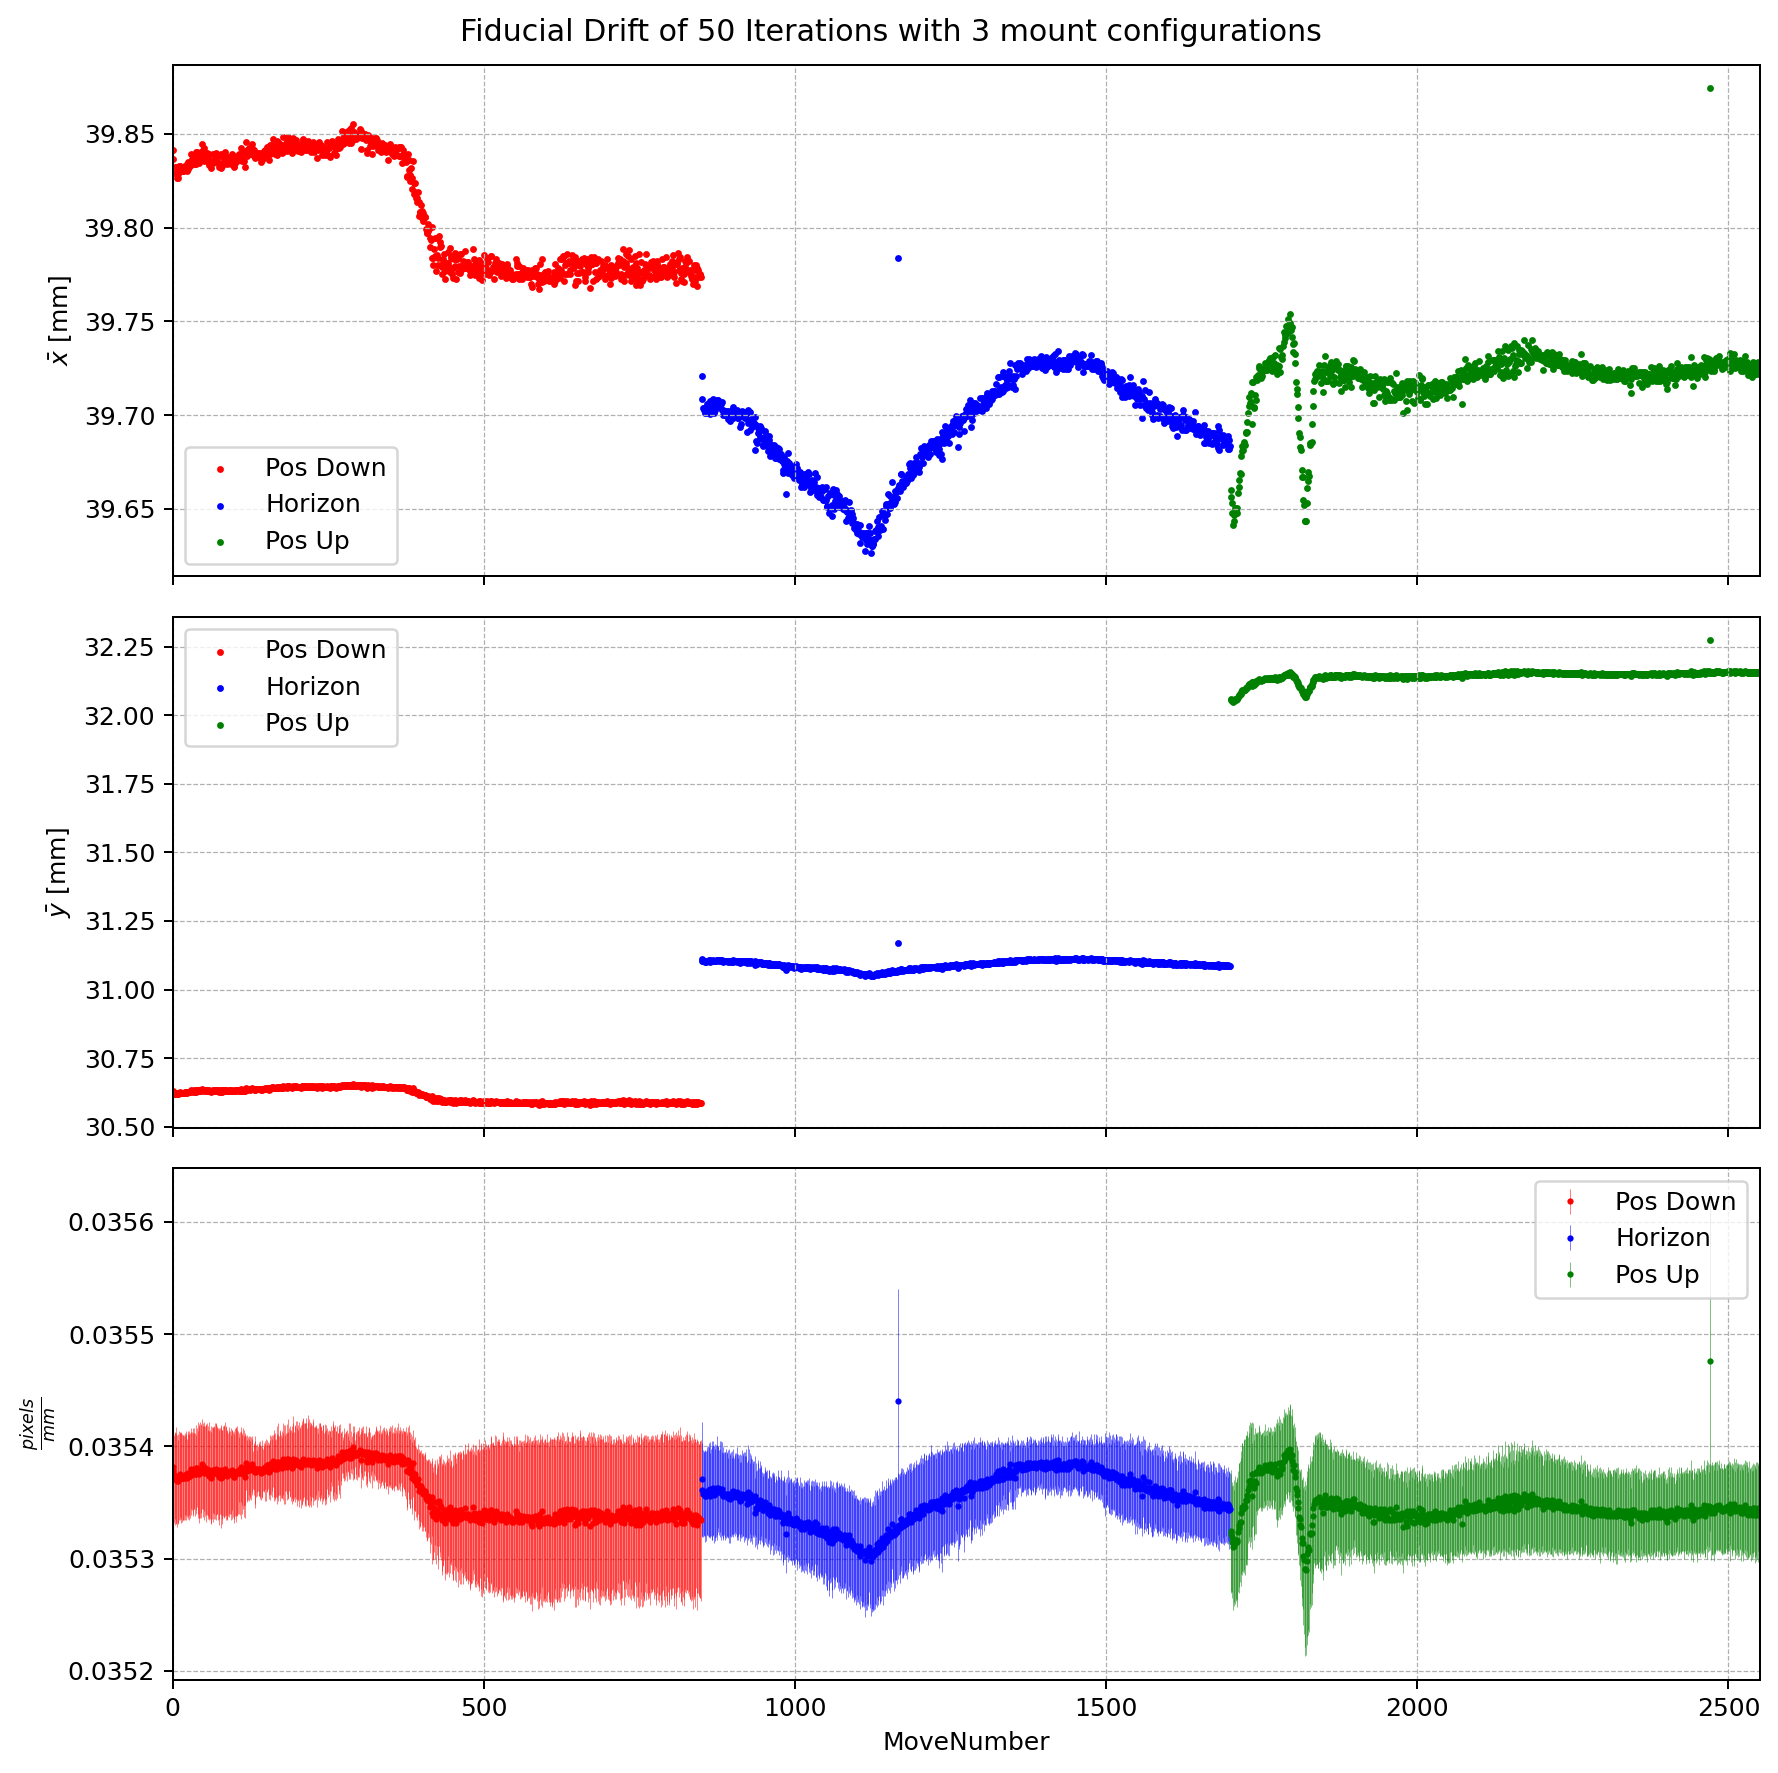

In [701]:
fig,axs = plt.subplots(3,1,figsize=[10,10],sharex=True)

fig.suptitle(title)

# First row - mean x fiducial position
init = 0
for j in range(len(MountConfigs)):
    axs[0].scatter(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[17]])+init),
             df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[[17,19,21,23]]].mean(axis=1)*df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             color=colors[j],label=MountConfigs[j],s=3)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[0].set_ylabel(r'$\bar{x}$ [mm]')
axs[0].set_xlim(0,len(df))

# Second row - mean y fiducial position
init = 0
for j in range(len(MountConfigs)):
    axs[1].scatter(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[18]])+init),
             df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[[18,20,22,24]]].mean(axis=1)*df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             color=colors[j],label=MountConfigs[j],s=3)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[1].set_ylabel(r'$\bar{y}$ [mm]')
axs[1].set_xlim(0,len(df))

# Third row - pix/mm and sig pix/mm errorbar fig
init = 0
for j in range(len(MountConfigs)):
    axs[2].errorbar(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])+init),
             df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             yerr=df[df['Mount Configuration']==MountConfigs[j]]['sigpix2mm'],color=colors[j],
             label=MountConfigs[j],capsize=0, fmt='.',elinewidth=.2,markersize=3)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[2].set_ylabel(r'$\frac{pixels}{mm}$')
axs[2].set_xlabel('MoveNumber')
axs[2].set_xlim(0,len(df))
for i in range(3):
    axs[i].grid(linestyle='--',linewidth=0.5)
    axs[i].legend(loc=legendloc)
    
fig.tight_layout()
    
if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)

plt.show()

# Fiducial positions moving over time

In [704]:
fid_index_start = 17
MountConfigs = np.unique(df['Mount Configuration'])
colors = ['red','blue','green']
title = 'FiducialMovements'
save=True

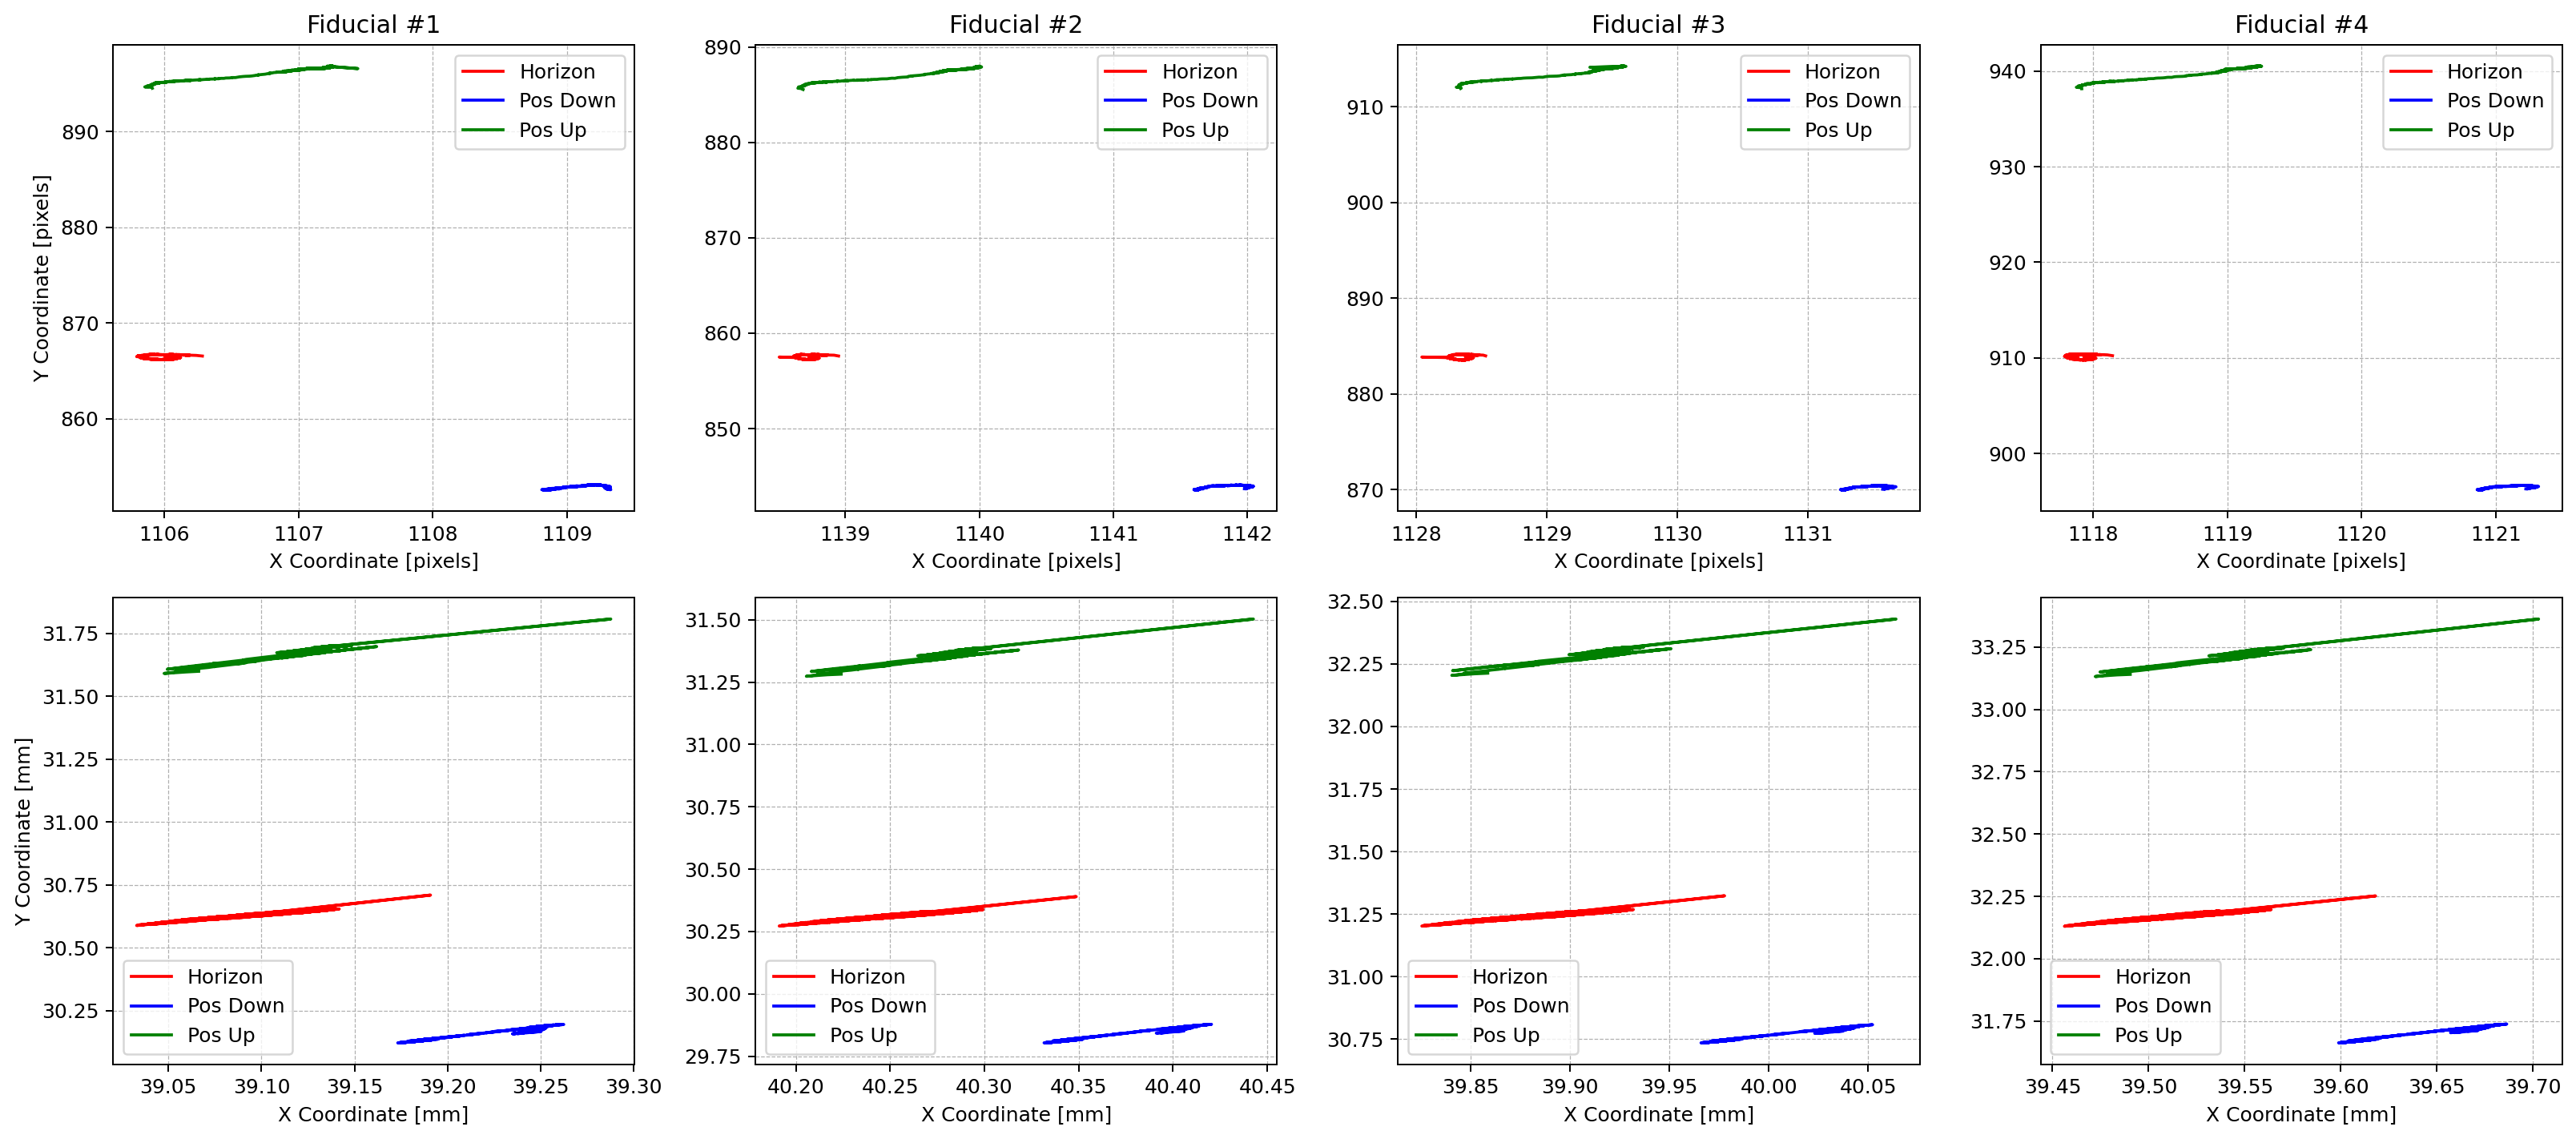

In [705]:
fig, axs = plt.subplots(2,4,figsize=[18,8])

# Upper row
for j in range(4):
    for k in range(3):
        axs[0,j].grid(linestyle='--',linewidth=0.5)
        axs[0,j].plot(df[df['Mount Configuration']==MountConfigs[k]][df.columns.values[fid_index_start+2*j]],
                    df[df['Mount Configuration']==MountConfigs[k]][df.columns.values[fid_index_start+2*j+1]],
                    color=colors[k],label=MountConfigs[k])
    axs[0,j].legend()
    axs[0,j].set_xlabel('X Coordinate [pixels]')
    axs[0,j].set_title('Fiducial #'+str(j+1))
    axs[0,j].locator_params(axis='x', nbins=7)

axs[0,0].set_ylabel('Y Coordinate [pixels]')

# Lower Row
for j in range(4):
    for k in range(3):
        axs[1,j].grid(linestyle='--',linewidth=0.5)
        axs[1,j].plot(df[df['Mount Configuration']==MountConfigs[k]][df.columns.values[fid_index_start+2*j]]*df[df['Mount Configuration']==MountConfigs[k]]['pix2mm'],
                    df[df['Mount Configuration']==MountConfigs[k]][df.columns.values[fid_index_start+2*j+1]]*df[df['Mount Configuration']==MountConfigs[k]]['pix2mm'],
                    color=colors[k],label=MountConfigs[k])
    axs[1,j].legend()
    axs[1,j].set_xlabel('X Coordinate [mm]')

axs[1,0].set_ylabel('Y Coordinate [mm]')
fig.tight_layout()

if save:
    plt.savefig(figPath+title+".jpg",dpi=180)

plt.show()

# $\bar{\alpha}$ & $\sigma_{\alpha}$ vs. movenumber

In [726]:
niter = 50

save= True
title = '50 ArcTests for each mount configuration'

Transitions = np.array([r'Positioner down $\rightarrow$ Horizon',r'Horizon $\rightarrow$ Positioner up'])
Transition_colors = np.array(['red','blue'])

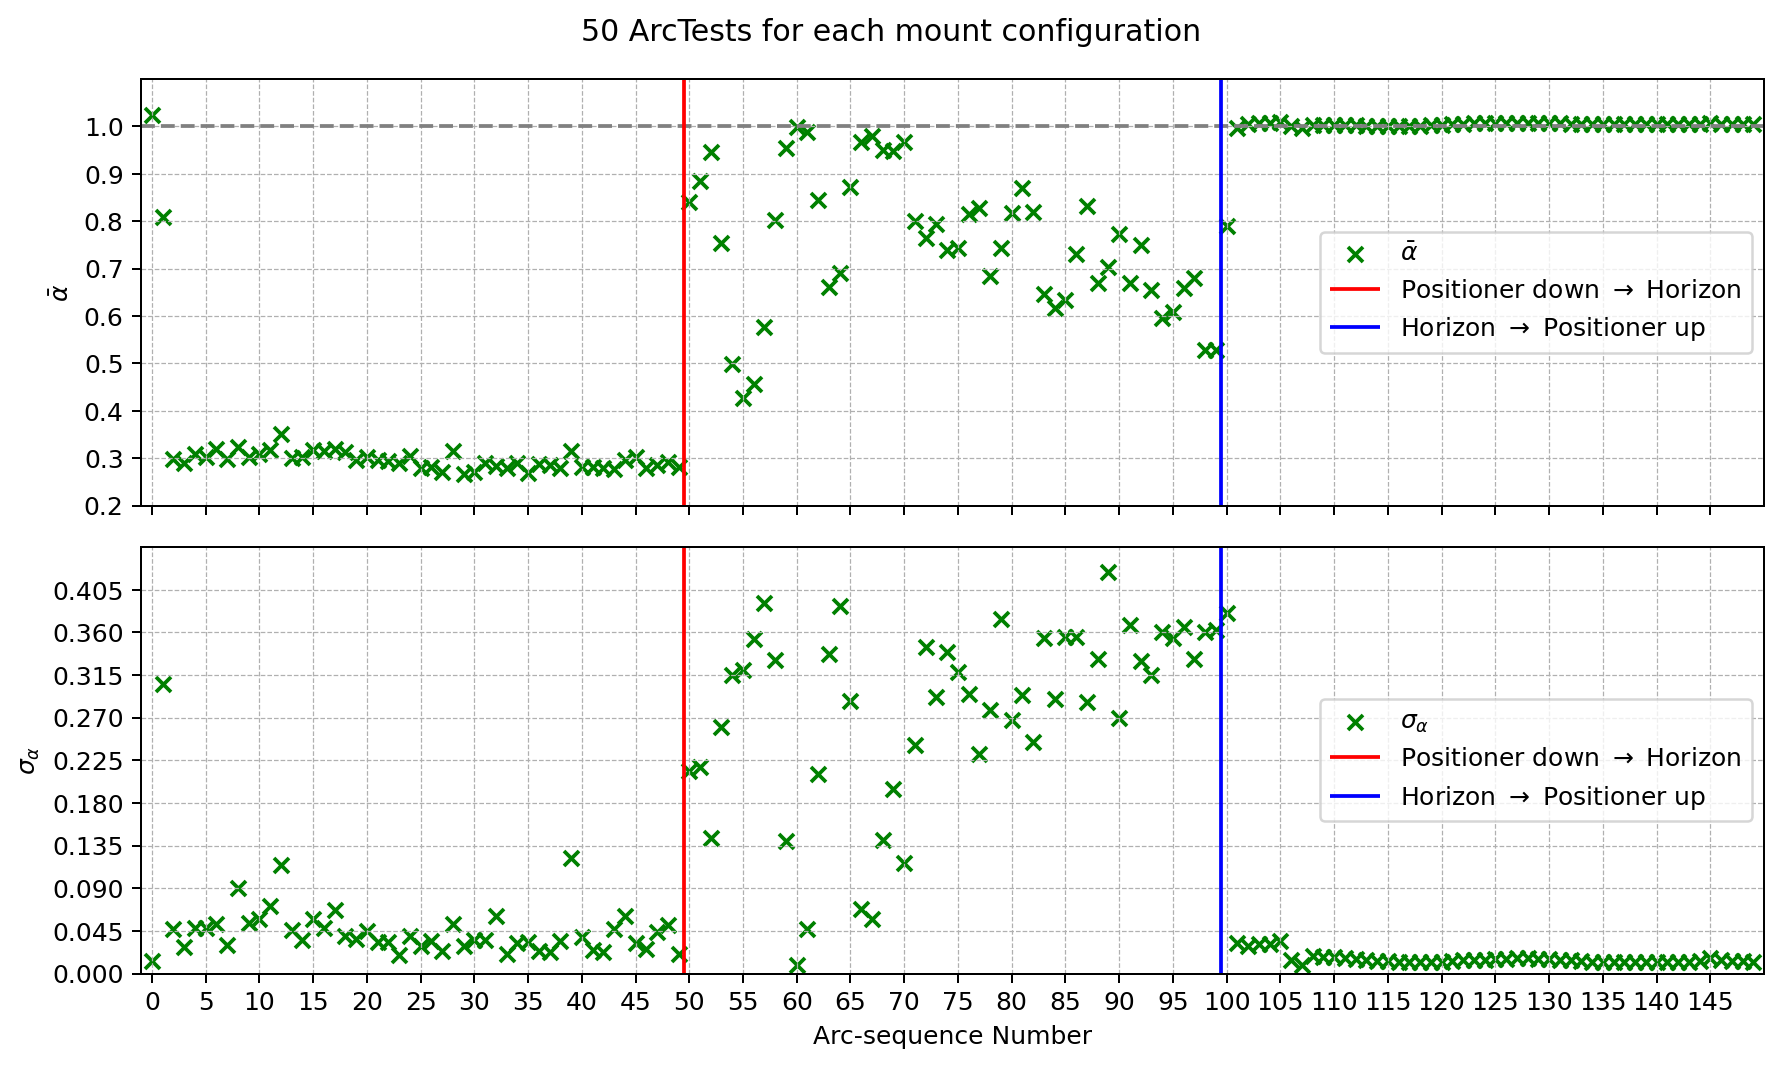

In [727]:
fig,axs = plt.subplots(2,1,figsize=[10,6],sharex=True)

fig.suptitle(title)

ylimit = [0.2,1.1]
ystep = 0.1

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].hlines(1,-1,len(np.unique(df['ArcSession']))+1,linestyle='--',colors='grey')
axs[0].set_xlim(-1,max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
# axs[0].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=1))
axs[0].scatter(np.linspace(0,len(np.unique(df['ArcSession']))-1,num=len(np.unique(df['ArcSession']))), mean_alpha,label=r"$\bar{\alpha}$",marker='x',color='green')
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
for sesh in range(1,len(mean_alpha)//niter):
    axs[0].vlines(sesh*niter-0.5,ylimit[0],ylimit[1],label=Transitions[sesh-1],color=Transition_colors[sesh-1])
axs[0].legend(loc=5)

ylimit = [0,0.45]
ystep = (ylimit[1]-ylimit[0])/10

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].set_xlim(-1,max(df['ArcSession'])+1)
axs[1].set_xlabel("Arc-sequence Number")
axs[1].set_ylabel(r"$\sigma_{\alpha}}$")
axs[1].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=5))
axs[1].scatter(np.linspace(0,len(np.unique(df['ArcSession']))-1,num=len(np.unique(df['ArcSession']))), std_alpha,label=r"$\sigma_{\alpha}}$",marker='x',color='green')
axs[1].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[1].set_ylim(ylimit[0],ylimit[1])
for sesh in range(1,len(mean_alpha)//niter):
    axs[1].vlines(sesh*niter-0.5,ylimit[0],ylimit[1],label=Transitions[sesh-1],color=Transition_colors[sesh-1])
axs[1].legend(loc=5)

fig.tight_layout()

if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)

plt.show()

# $\alpha$ vs. movenumber for selected arcsequences

In [655]:
arc_sequence_Number = 9
ramp = 1.995
backlash=1.9
req_move = 15
save=True
label = 'Initial 10 ArcTests - arcsequence '+str(arc_sequence_Number)

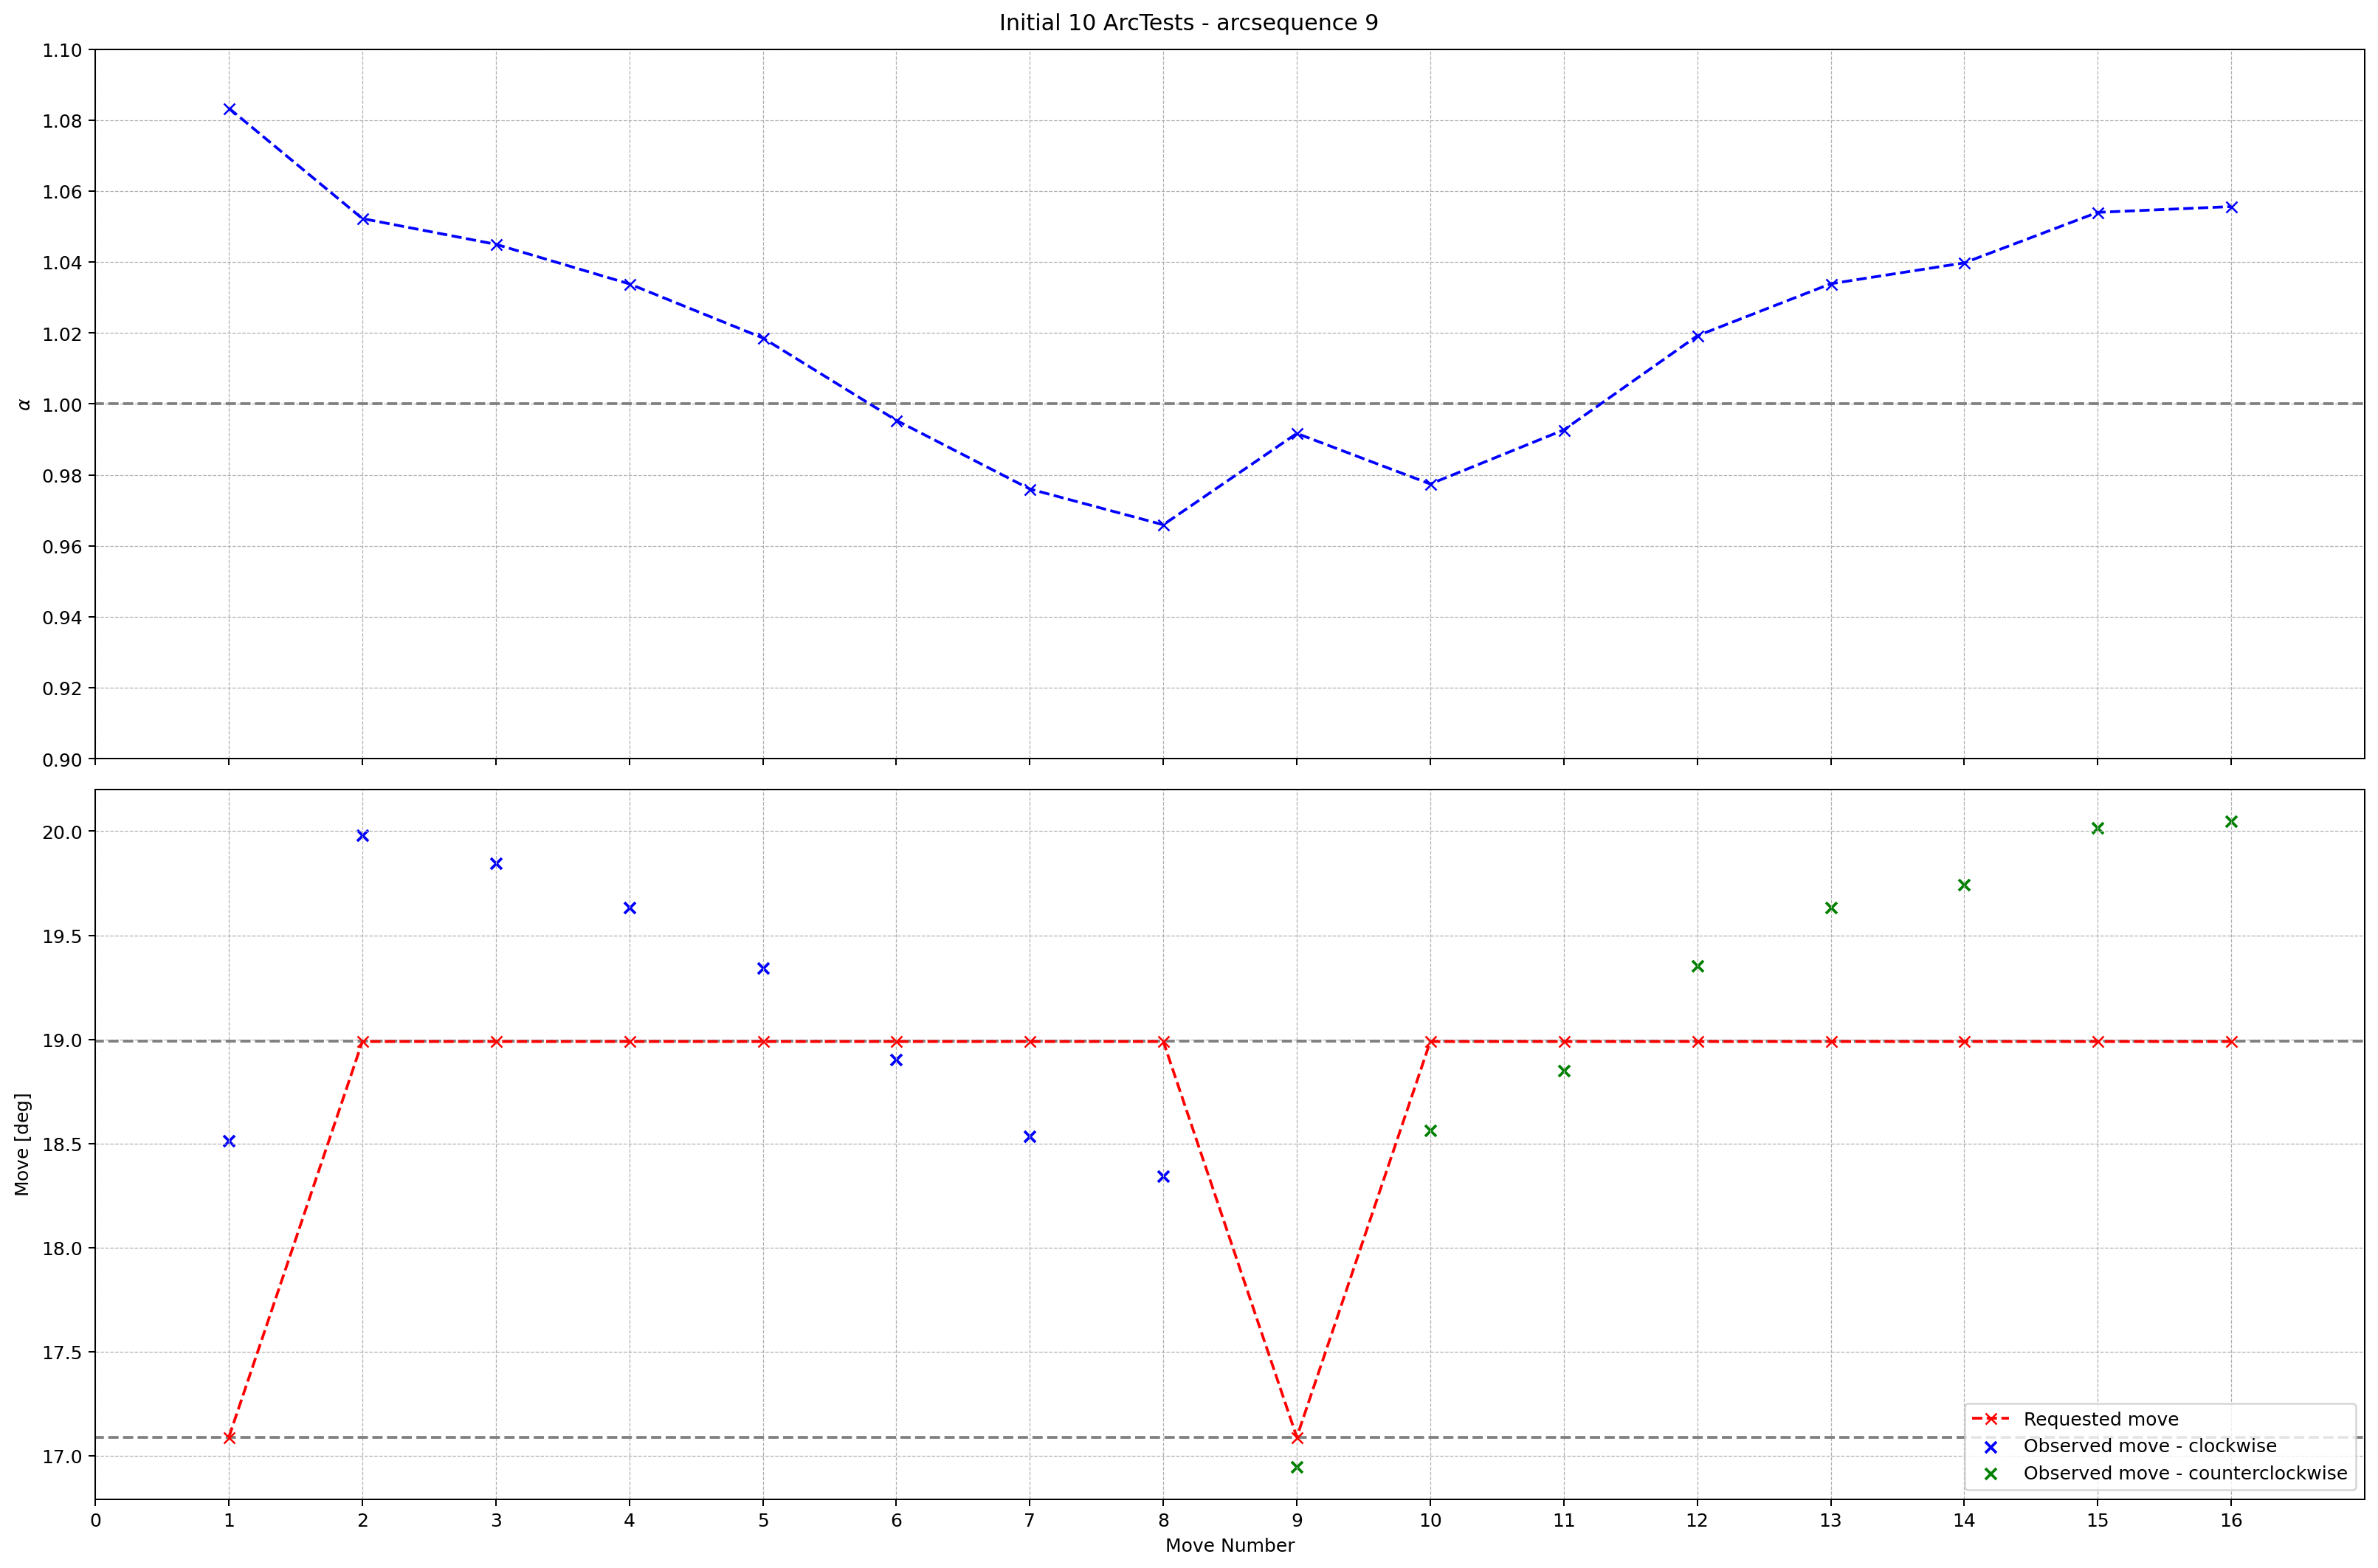

In [663]:
maskedDF = df[df['ArcSession']==arc_sequence_Number].reset_index(drop=True)

fig,axs = plt.subplots(2,1,figsize=[18,12],sharex=True)

fig.suptitle(label)

axs[0].set_ylim(0.9,1.1)
axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].hlines(0,-1,len(maskedDF)+1,linestyle='--',colors='grey')
axs[0].hlines(1,-1,len(maskedDF)+1,linestyle='--',colors='grey')
axs[0].set_xlim(0,len(maskedDF))
axs[0].set_ylabel(r"$\alpha$")
axs[0].plot(np.linspace(0,len(maskedDF),num=len(maskedDF),endpoint=False), maskedDF["Alpha"],marker='x',linestyle='dashed',color='blue')
axs[0].set_xticks(np.arange(0,len(maskedDF),step=1))
axs[0].set_yticks(np.arange(0.9,1.1,step=.02))

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].hlines(15+2*ramp-backlash,-1,len(maskedDF)+1,linestyle='--',colors='grey')
axs[1].hlines(15+2*ramp,-1,len(maskedDF)+1,linestyle='--',colors='grey')
axs[1].set_xlabel("Move Number")
axs[1].set_ylabel(r"Move $[\deg]$")
ccwMask = maskedDF['direction'].str.contains('ccw') 
cwMask = -ccwMask
axs[1].scatter(np.arange(min(maskedDF['Observed Move'][cwMask].index),max(maskedDF['Observed Move'][cwMask].index)+1,),
               maskedDF['Observed Move'][cwMask], label="Observed move - clockwise",marker='x',color='blue')
axs[1].scatter(np.arange(min(maskedDF['Observed Move'][ccwMask].index),max(maskedDF['Observed Move'][ccwMask].index)+1),
               maskedDF['Observed Move'][ccwMask],label="Observed move - counterclockwise",marker='x',color='green')
axs[1].plot(np.arange(min(maskedDF['Requested Move'].index),max(maskedDF["Requested Move"].index)+1),
            maskedDF['Requested Move'],label="Requested move",marker='x',linestyle='dashed',color='red')
axs[1].legend()
# axs[1].set_yticks(np.arange(16.5,19.5,step=.2))
# axs[1].set_ylim(16.5,19.5)

fig.tight_layout()

if save:
    plt.savefig(figPath+label+'.jpg',dpi=180)

plt.show()

# Histograms of $\bar{\alpha}$ & $\alpha$

In [766]:
ymax = 450
colors = ['red','blue','green']
x_hist_range = [0.2,1.1]
save=True
label = 'Histograms for 50 Iterations'
kwargs = dict(histtype='stepfilled', alpha=0.2, bins=40, range=(x_hist_range[0],x_hist_range[1])
             )

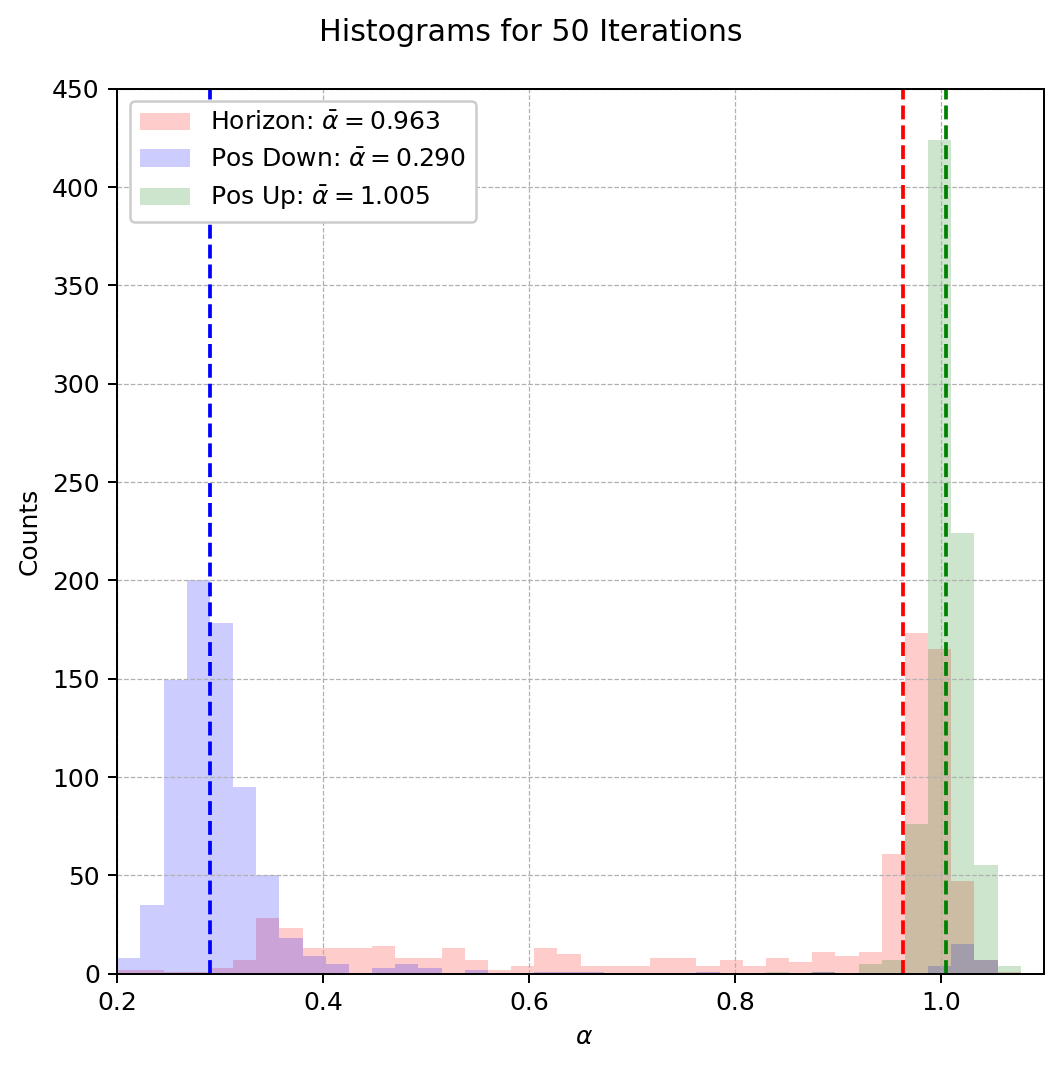

In [767]:
fig,ax = plt.subplots(figsize=[6,6])

fig.suptitle(label)

ax.grid(linestyle='--',linewidth=0.5)
for i in range(len(np.unique(df['Mount Configuration']))):
    label_config = np.unique(df['Mount Configuration'])[i]
    med_val = np.nanmedian(df[df['Mount Configuration']==np.unique(df['Mount Configuration'])[i]]["Alpha"])
    ax.hist(df[df['Mount Configuration']==np.unique(df['Mount Configuration'])[i]]['Alpha'],
            color=colors[i], label=label_config+r': $\bar{\alpha} = $'+f'{med_val:.3f}', **kwargs)

    ax.vlines(med_val,0,ymax,
              linestyle='--',color=colors[i])
ax.set_ylim(0,ymax)
ax.legend(loc=2,framealpha=1)
ax.set_xlim(x_hist_range[0],x_hist_range[1])
ax.set_xlabel(r' $\alpha$')
ax.set_ylabel('Counts')

fig.tight_layout()

if save:
    plt.savefig(figPath+str(label)+'.jpg',dpi=180)

plt.show()